<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [867]:
import requests
from bs4 import BeautifulSoup
import json
from typing import Dict, List

%matplotlib inline

In [791]:
base_url = 'https://www.slf.ch/'
archive_parent = 'fr/bulletin-davalanches-et-situation-nivologique/archives.html?tx_wslavalanches_archiv%5Bpath%5D=%2Fuser_upload%2Fimport%2Flwdarchiv%2Fpublic%2F&tx_wslavalanches_archiv%5Baction%5D=showArchiv&tx_wslavalanches_archiv%5Bcontroller%5D=Avalanche&cHash=c71751a643ec4629e21b0306033ccd59'

In [836]:
def extract_folders(url: str) -> Dict[str, str]:
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'html.parser')
    folders = [folder.find('a') for folder in soup.findAll(class_='folder')]
    return {str(folder.contents[2]).split(',')[0].strip(): folder['href'] for folder in folders}

def extract_folders_rec(url: str, max_level: int = 3, curr_level: int = 0):
    full_url = base_url + url
    subfolders = extract_folders(full_url)
    if curr_level < max_level:
        for subfolder in subfolders:
            print('subfolder: {}'.format(subfolder))
            subfolder_url = subfolders[subfolder]
            subfolders[subfolder] = extract_folders_rec(subfolder_url, max_level, curr_level + 1)
    return subfolders

In [862]:
hier_0 = extract_folders_rec(base_url + archive_parent, max_level=1)

subfolder: Produits les plus récents
subfolder: 2018
subfolder: 2017
subfolder: 2016
subfolder: 2015
subfolder: 2014
subfolder: 2013
subfolder: 2012
subfolder: 2011
subfolder: 2010
subfolder: 2009
subfolder: 2008
subfolder: 2007
subfolder: 2006
subfolder: 2005
subfolder: 2004
subfolder: 2003
subfolder: 2002
subfolder: 2001
subfolder: 2000
subfolder: 1999
subfolder: 1998


In [891]:
# take fr/en when possible
# take color only when possible
# do not take regional

def folders_filter(folders: Dict[str, str]) -> Dict[str, str]:
    # language picking
    if 'en' in folders:
        return {'en': folders['en']}
    if 'fr' in folders:
        return {'fr': folders['fr']}
    if 'de' in folders:
        return {'de': folders['de']}
    
    new_folders = folders.copy()
    for key in folders:
        if 'regional' in key.lower() or 'régional' in key.lower():
            new_folders.pop(key)
        if 'icône' in key.lower() or 'icone' in key.lower():
            new_folders.pop(key)
        if 'Schneedeckenstabilität' in key:
            new_folders.pop(key)
    return new_folders

def files_filter(files_url: List[str]) -> List[str]:
    new_files_url = []
    for fu in files_url:
        f = path.basename(fu)
        if 'bw' not in f:
            new_files_url.append(fu)
    return new_files_url

In [892]:
hier_0['2017'].keys()

dict_keys(["Bulletin d'avalanches", 'FR: Regionale hazard map', 'FR: Einzelne Gefahrengebiete', 'Carte du danger', 'Carte des Icônes', 'FR: Neuschnee 1 Tag', 'FR: Neuschnee 3 Tage', 'Cartes de neige', 'Enneigement à 2000 m', 'FR: Schneehöhe %', 'FR: Schneedeckenstabilität', 'sw'])

In [898]:
from os import path
import os

def extract_files(url: str):
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    files = [folder.find('a')['href'] for folder in soup.findAll(class_='linkedListPoint')]
    return files

u = 'https://www.slf.ch/fr/bulletin-davalanches-et-situation-nivologique/archives.html?tx_wslavalanches_archiv%5Bpath%5D=%2Fuser_upload%2Fimport%2Flwdarchiv%2Fpublic%2F2018%2Fhstop%2Ffr%2Fgif%2F&tx_wslavalanches_archiv%5Baction%5D=showArchiv&tx_wslavalanches_archiv%5Bcontroller%5D=Avalanche&cHash=3a2d286c7428ec5abc465a7412ad6f65'
extract_files(u)

def fetch_all(url: str, dest: str, curr_path: str = '', count: int = 0):
    fs = extract_files(url)
#     fs = files_filter(fs)
    for file_url in fs:
        dest_file = path.join(dest, curr_path, path.basename(file_url))
        if not os.path.exists(dest_file):
            content = requests.get(path.join(base_url, file_url)).content
            with open(dest_file, 'wb') as f:
                f.write(content)
            count += 1
        print('count {}\t{}'.format(count, path.join(curr_path, path.basename(file_url))), end='\r')

    sub_directories = extract_folders(url)
    sub_directories = folders_filter(sub_directories)
    for name, sub_url in sub_directories.items():
        new_path = path.join(curr_path, name)
        create_dir(path.join(dest, new_path))
        count = fetch_all(base_url + sub_url, dest, curr_path=new_path, count=count)
        
    return count

def create_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)


In [899]:
def files_generator(url: str):
    fs = extract_files(url)
    fs = files_filter(fs)
    for file_url in fs:
        yield file_url

    sub_directories = extract_folders(url)
    sub_directories = folders_filter(sub_directories)
    for name, sub_url in sub_directories.items():
        for f in files_generator(base_url + sub_url):
            yield f
    

In [ ]:
entry_point = 'https://www.slf.ch/fr/bulletin-davalanches-et-situation-nivologique/archives.html?tx_wslavalanches_archiv%5Bpath%5D=%2Fuser_upload%2Fimport%2Flwdarchiv%2Fpublic%2F&tx_wslavalanches_archiv%5Baction%5D=showArchiv&tx_wslavalanches_archiv%5Bcontroller%5D=Avalanche&cHash=c71751a643ec4629e21b0306033ccd59'
destination = './data/'
# no bw, en-fr-de in order, no profile, no refional, no icone

# fetch_all(entry_point, destination)
with open('files_to_download_with_bw', 'w') as dest:
    dest.writelines(map(lambda x: base_url + x + '\n', files_generator(entry_point)))


In [793]:
hierarchy = extract_folders_rec(archive_parent, max_level=2)

subfolder: Produits les plus récents
subfolder: 2018
subfolder: Bulletin d'avalanches
subfolder: FR: Neuschnee 1 Tag
subfolder: FR: Neuschnee 3 Tage
subfolder: Cartes de neige
subfolder: Enneigement à 2000 m
subfolder: FR: Schneehöhe %
subfolder: FR: Schneedeckenstabilität
subfolder: 2017
subfolder: Bulletin d'avalanches
subfolder: FR: Regionale hazard map
subfolder: FR: Einzelne Gefahrengebiete
subfolder: Carte du danger
subfolder: Carte des Icônes
subfolder: FR: Neuschnee 1 Tag
subfolder: FR: Neuschnee 3 Tage
subfolder: Cartes de neige
subfolder: Enneigement à 2000 m
subfolder: FR: Schneehöhe %
subfolder: FR: Schneedeckenstabilität
subfolder: sw
subfolder: 2016
subfolder: Bulletin d'avalanches
subfolder: FR: Regionale hazard map
subfolder: FR: Einzelne Gefahrengebiete
subfolder: Carte du danger
subfolder: Carte des Icônes
subfolder: FR: Neuschnee 1 Tag
subfolder: FR: Neuschnee 3 Tage
subfolder: Cartes de neige
subfolder: Enneigement à 2000 m
subfolder: FR: Schneehöhe %
subfolder: FR:

KeyboardInterrupt: 

In [789]:
a + timedelta(days=1)

def dates_between(start, stop):
    while start <= stop:
        yield start
        start += timedelta(days=1)
        
def hydrological_year(at_date):
    if at_date.month > 6:
        return at_date.year + 1
    else:
        return at_date.year
    

def danger_map_url(at_date):
    danger_map_pattern = 'https://www.slf.ch/fileadmin/user_upload/import/lwdarchiv/public/{}/nbk/de/gif/{}_nbk_de_c.gif'
    return danger_map_pattern.format(hydrological_year(at_date), at_date.strftime('%Y%m%d'))

files = list(danger_map_url(d) for d in dates_between(date(2002, 11, 14), date(2003, 5, 4)))

In [32]:
for d in dates_between(date(2002, 11, 14), date(2003, 5, 4)):
    url = danger_map_url(d)
    path = '../data/{}/danger/{}.gif'.format(hydrological_year(d), d.strftime('%Y%m%d'))
    res = requests.get(url)
    with open(path, 'wb') as f:
        f.write(res.content)

In [212]:
import numpy as np
from PIL import Image

black = [0, 0, 0, 255]
white = [255, 255, 255, 255]
green = [204, 255, 102, 255]
yellow = [255, 255, 0, 255]
orange = [255, 153, 0, 255]
red = [255, 0, 0, 255]

In [756]:
def keep_colors(img, colors, replace_with=(255,) * 4):
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[~keep] = replace_with
    return new_img

In [757]:
import cv2
from skimage import measure
from PIL import Image, ImageDraw

def numpies(o):
    if not isinstance(o, np.ndarray):
        o = np.array(o)
    return o

def color_contours(img, color):
    img = numpies(img)
    color = numpies(color)
    mask = (img == color[:3]).all(axis=-1)
    monocholor = img.copy()
    monocholor[~mask] = 255
    contours = measure.find_contours(mask, 0.5)
    
    # heuristic filter for contours
    filter_contours = []
    for c in contours:
        region = Image.new("L", [img.shape[1], img.shape[0]], 0)
        ImageDraw.Draw(region).polygon(list(map(lambda t: (t[1],t[0]), c)), fill=1)
        region = np.array(region).astype(bool)
        white_ratio = (monocholor == 255).all(axis=-1)[region].mean()
        if white_ratio <= .3:
            filter_contours.append(c)
    return filter_contours


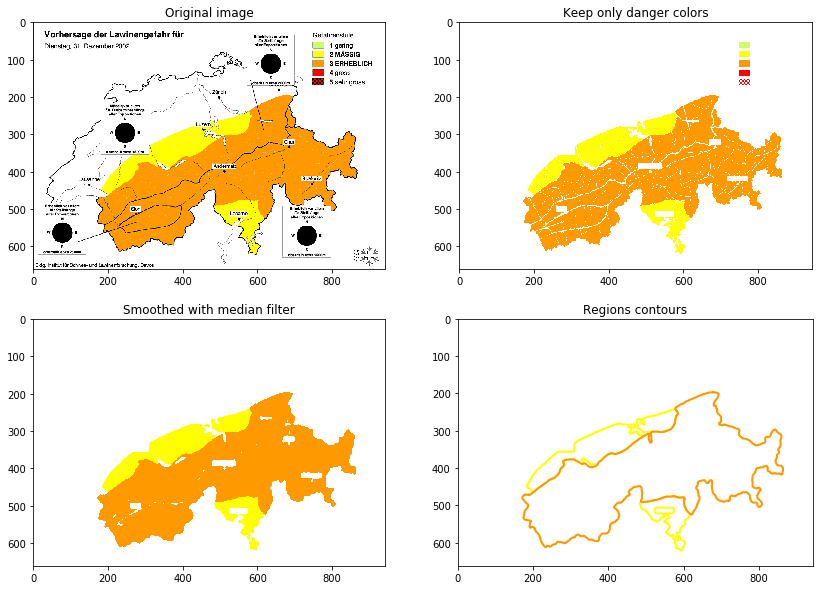

In [785]:
from pylab import contour
import matplotlib.pyplot as plt
from PIL import ImageFilter

fig, axes = plt.subplots(2, 2, figsize=(14,10))

path = '../data/danger/2003/20021230.gif'
img = Image.open(path)
img = img.convert('RGBA')
img_arr = np.array(img)
axes[0][0].imshow(img_arr);
axes[0][0].set_title('Original image');

regions_only = keep_colors(img_arr, [green, yellow, orange, red])
axes[0][1].imshow(regions_only);
axes[0][1].set_title('Keep only danger colors');

regions_only[50:200,740:790,:] = 255
regions_only = Image.fromarray(regions_only).convert('RGB')
smoothed = regions_only.filter(ImageFilter.MedianFilter(7))
axes[1][0].imshow(smoothed);
axes[1][0].set_title('Smoothed with median filter');

axes[1][1].set_xlim([0, img_arr.shape[1]])
axes[1][1].set_ylim([0, img_arr.shape[0]])
axes[1][1].invert_yaxis()
axes[1][1].set_title('Regions contours')
for color in [green, yellow, orange, red]:
    contours = color_contours(smoothed, color)
    for contour in contours:
        axes[1][1].plot(contour[:, 1], contour[:, 0], linewidth=2, c=[x / 255 for x in color])


In [786]:
zurich_pix = np.array([503, 202])
zurich_map = np.array([8.542084693908691, 47.37214023852198])
lausanne_pix = np.array([150, 437])
lausanne_map = np.array([6.631450653076172, 46.52060318945508])          
stmoritz_pix = np.array([753, 435])
stmoritz_map = np.array([9.837398529052734, 46.49768324964543])

# 662, 944

pix = np.vstack([zurich_pix, lausanne_pix, stmoritz_pix])
coord = np.vstack([zurich_map, lausanne_map, stmoritz_map])
pix_ext = np.vstack([np.ones((1,3)), pix.T])
coord_ext = np.vstack([np.ones((1,3)), coord.T])
T = np.linalg.solve(pix_ext.T, coord_ext.T)

def transform_pix2map(points):
    """n x 2 array"""
    points_ext = np.hstack([np.ones((points.shape[0], 1)), points])
    points_map = points_ext.dot(T)
    return points_map[:, 1:]


In [787]:
import json
import visvalingamwyatt as vw

SMOOTHING_THRESHOLD = 0.0001
ADJUSTEMENT = np.array([[.05, 0.]])

geo_json = {
  "type": "FeatureCollection",
  "features": []
}

for danger_level, color in enumerate([green, yellow, orange, red]):
    for contour in color_contours(smoothed, color):
        contour_right = contour.copy()
        contour_right[:,0] = contour[:,1]
        contour_right[:,1] = contour[:,0]
        contour_right = transform_pix2map(contour_right)
        simplifier = vw.Simplifier(contour_right)
        contour_right = simplifier.simplify(threshold=SMOOTHING_THRESHOLD)
        contour_right = contour_right + ADJUSTEMENT
        geo_json['features'].append({
            "type": "Feature",
            "properties": {
                "date": "TODO",
                "danger_level": danger_level + 1
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [ list(reversed(contour_right.tolist())) ]
            }
        })

json.dump(geo_json, open('bla.json', 'w'))

In [788]:
import folium

switzerland = (46.875893, 8.289321)
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'
m = folium.Map(location=switzerland, zoom_start=8, tiles=tiles, attr=attr)               

colors = ['#ccff66', '#ffff00', '#ff9900', '#ff0000']

def style_function(risk_region):
    level = risk_region['properties']['danger_level']
    color = colors[level - 1]
    return {
        'fillOpacity': .5,
        'weight': 0,
        'fillColor': color,
#         'weight': 1,
#         'opacity': 1,
        'color': 'white',
    }

folium.GeoJson(
    geo_json,
    name='geojson',
    style_function=style_function
).add_to(m)

m